# IBM comparing methods - LDA Pros

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd 
import numpy as np

# NLP packages
import re
import nltk
import string
import enchant
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline   

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import shuffle

In [2]:
df_IBM=pd.read_csv("IBM.csv",encoding = "UTF-8")  #"ISO-8859-1"
#change the order
df_IBM =df_IBM[[ 'Employee ID',
                 'Date',
                 'Location',
                 'Employee Status',
                 'Employee Position',
                 'Overall Rating',
                 'Work Life Balance',
                 'Company Culture',
                 'Career Opportunity',
                 'Benefit and Compensation',
                 'Senior Management',
                 'Helpful Count',
                 'Evaluation',
                 'Overall Comment',
                 'Pros',
                 'Cons',
                 'Advice']]

df_IBM['Company Name'] = df_IBM.apply(lambda _: 'IBM', axis=1)

In [3]:
# create 2 more columns which is combined review & review length
# combined review
df_IBM['CombineReview'] = df_IBM[df_IBM.columns[-3:]].apply(lambda x: ' '.join(x.astype(str).astype(str)), axis=1)
# review length
df_IBM['review length'] = df_IBM['CombineReview'].apply(len)

## New dataframe: matching the employee ID for splitted Pros comments 

In [4]:
IBM_pro_reviews=df_IBM[['Employee ID','Pros', 'Company Name']]
splitted_pros = pd.DataFrame(IBM_pro_reviews.Pros.str.split(r"\.|\,|\+|\?|\!|\;").tolist(), \
                             index=IBM_pro_reviews['Employee ID']).stack()

splitted_pros = splitted_pros.reset_index()[['Employee ID', 0]] 
splitted_pros.columns = ['Employee ID', 'Pros'] 
cleaned_pros=[item for item in splitted_pros.Pros if len(str(item).split())>=2]
splitted_pros=splitted_pros.loc[splitted_pros['Pros'].isin(cleaned_pros)]

#splitted_pros['Company Name'] = splitted_pros.apply(lambda _: 'IBM', axis=1)
splitted_pros.head()

,Employee ID,Pros
0,empReview_17651831,The working culture and environment is good here
1,empReview_17651831,Freedom to employees and facility of work fro...
3,empReview_19452793,Good working environment and opportunity to wo...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...
6,empReview_4852131,But I found this to be fairly pervasive polic...


In [5]:
stop_words=stopwords.words('english')
more_stopwords = """etc nan also some just have from it's /via &amp; that they your there this into would can't"""
stop_words += more_stopwords.split()

In [6]:
pros=["".join(item) for item in splitted_pros.Pros]
pros[0:5]

['The working culture and environment is good here',
 ' Freedom to employees and facility of work from home',
 'Good working environment and opportunity to work different countries',
 "Disclaimer: A lot of what I'm writing below of course depends on the work area and management chain",
 ' But I found this to be fairly pervasive policies in IBM in my 9']

In [7]:
d = enchant.Dict("en_US")    # english dictionary

def text_cleaning(text):
    text=text.lower()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    tokens=nltk.word_tokenize(nopunc)
    tokens=[token for token in tokens if token.isalpha()]
    tokens=[token for token in tokens if token not in stop_words]
    tagged_tokens= nltk.pos_tag(tokens)
        
    words=filter(lambda x: d.check(x), tokens)
    clean_word=[word for word in words if word not in stop_words]
    return clean_word, tagged_tokens 

def taggedwords(review_list):
    packed_words=[]
    for review in review_list:     # use target list for analysis here is cons
        packed_words.append(text_cleaning(review))
        
    review_words,tagged_tokens=zip(*packed_words)
    return tagged_tokens

In [8]:
# obtain tagged_tokens in pros & cons
pros_tagged_tokens=taggedwords(pros)

#cons_tagged_tokens=taggedwords(cons)

In [9]:
# obtain lemmatized reviews
wordnet_lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

pros_lemmatized_words=[] 
for idx, doc in enumerate(pros_tagged_tokens):
    pros_lemmatized_words.append([wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in doc])
len(pros_lemmatized_words)

#cons_lemmatized_words=[] 
#for idx, doc in enumerate(cons_tagged_tokens):
#    cons_lemmatized_words.append([wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in doc])
#len(cons_lemmatized_words)

90161

In [10]:
pros_lemmatized_text=[" ".join(item) for item in pros_lemmatized_words]

# add the lemmatized pros in data frame 
splitted_pros.loc[:,'lemmatized_pros'] = pros_lemmatized_text
splitted_pros.head()

,Employee ID,Pros,lemmatized_pros
0,empReview_17651831,The working culture and environment is good here,working culture environment good
1,empReview_17651831,Freedom to employees and facility of work fro...,freedom employee facility work home
3,empReview_19452793,Good working environment and opportunity to wo...,good work environment opportunity work differe...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...,disclaimer lot im write course depend work are...
6,empReview_4852131,But I found this to be fairly pervasive polic...,find fairly pervasive policy ibm


In [11]:
split_lemma_pros=splitted_pros.loc[splitted_pros['lemmatized_pros'].isin([item for item in splitted_pros.lemmatized_pros if len(str(item).split())>=2])]

split_lemma_pros.head()
len(split_lemma_pros)

,Employee ID,Pros,lemmatized_pros
0,empReview_17651831,The working culture and environment is good here,working culture environment good
1,empReview_17651831,Freedom to employees and facility of work fro...,freedom employee facility work home
3,empReview_19452793,Good working environment and opportunity to wo...,good work environment opportunity work differe...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...,disclaimer lot im write course depend work are...
6,empReview_4852131,But I found this to be fairly pervasive polic...,find fairly pervasive policy ibm


87294

In [12]:
# shuffle the data before clustering
pros_lemmatized_text=shuffle(split_lemma_pros)  # dataframe shuffle for later clustering
pros_lemmatized_text.head()

,Employee ID,Pros,lemmatized_pros
9097,empReview_14097495,Great place to learn/grow,great place learngrow
74821,empReview_12399850,- International environment,international environment
24743,empReview_7904838,o Ample parking,ample parking
3213,empReview_17227778,Got a very good amount of help from my seniors...,got good amount help senior technically improve
10734,empReview_13621219,good people,good people


In [48]:
lemma_pros=["".join(item) for item in pros_lemmatized_text.lemmatized_pros]
text_list = [i.split() for i in lemma_pros]
len(text_list)
text_list[0]

87294

['great', 'place', 'learngrow']

In [116]:
def bigrams(line):
    tokens = line.split(" ")
    return [(tokens[i], tokens[i+1]) for i in range(0, len(tokens)-1)]

In [131]:
results=[]
for line in lemma_pros:
    results.append(["_".join(item) for item in bigrams(line)])
results[0:2]

results_1=[" ".join(item) for item in results]
results_1[0:2]

bigram_list = [i.split() for i in results_1]
len(bigram_list)
bigram_list[0:2]

[['great_place', 'place_learngrow'], ['international_environment']]

['great_place place_learngrow', 'international_environment']

87294

[['great_place', 'place_learngrow'], ['international_environment']]

In [26]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')
print (dictionary)

Dictionary(18429 unique tokens: ['great', 'learngrow', 'place', 'environment', 'international']...)


In [28]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

len(doc_term_matrix)
print (doc_term_matrix[100])

87294

[(16, 1), (30, 1), (31, 1), (74, 1), (104, 1), (171, 2), (272, 1), (273, 1), (274, 1)]


### LDA 10 topics

In [32]:
from time import time
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

start = time()
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=15, id2word = dictionary, passes=50)
print('used: {:.2f}s'.format(time()-start))

used: 538.55s


In [33]:
print(ldamodel.print_topics(num_topics=2, num_words=4))

[(6, '0.069*"career" + 0.069*"good" + 0.039*"training" + 0.036*"skill"'), (4, '0.060*"technology" + 0.034*"help" + 0.034*"support" + 0.030*"always"')]


In [34]:
for i in ldamodel.print_topics(): 
    for j in i: 
        print (j)

0
0.216*"work" + 0.124*"home" + 0.095*"flexible" + 0.053*"flexibility" + 0.046*"hour" + 0.043*"time" + 0.031*"option" + 0.025*"office" + 0.019*"location" + 0.019*"schedule"
1
0.257*"great" + 0.152*"people" + 0.111*"work" + 0.036*"company" + 0.033*"excellent" + 0.027*"product" + 0.015*"ibm" + 0.015*"talented" + 0.011*"meet" + 0.010*"individual"
2
0.048*"one" + 0.047*"company" + 0.044*"ibm" + 0.042*"brand" + 0.041*"name" + 0.039*"world" + 0.027*"want" + 0.025*"value" + 0.025*"much" + 0.024*"make"
3
0.089*"pay" + 0.081*"nice" + 0.040*"take" + 0.034*"offer" + 0.025*"competitive" + 0.024*"right" + 0.023*"develop" + 0.022*"care" + 0.017*"system" + 0.016*"ibm"
4
0.060*"technology" + 0.034*"help" + 0.034*"support" + 0.030*"always" + 0.030*"long" + 0.030*"process" + 0.027*"still" + 0.025*"ibm" + 0.022*"use" + 0.021*"leave"
5
0.139*"benefit" + 0.103*"good" + 0.087*"culture" + 0.045*"salary" + 0.028*"decent" + 0.017*"free" + 0.016*"package" + 0.014*"health" + 0.014*"u" + 0.013*"average"
6
0.069*"

In [35]:
ldamodel.save('topic.model')

### load model 

In [37]:
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')

In [38]:
print(loading.print_topics(num_topics=2, num_words=4))

[(14, '0.141*"company" + 0.033*"large" + 0.033*"ibm" + 0.031*"year"'), (13, '0.062*"friendly" + 0.055*"global" + 0.048*"colleague" + 0.045*"give"')]


In [39]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [40]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

In [41]:
data = pyLDAvis.gensim.prepare(lda, c, d)
data

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
10     8.838811        1       1 -0.327469 -0.014970
12     8.748462        1       2  0.185526 -0.005929
14     8.332213        1       3  0.166177 -0.091915
1      7.786108        1       4 -0.143304 -0.270457
0      7.512862        1       5 -0.221753 -0.219582
6      7.335374        1       6 -0.061316  0.172680
2      6.817647        1       7  0.123043 -0.082560
8      6.740983        1       8  0.170631  0.002918
11     6.050856        1       9  0.125339  0.030851
4      5.868707        1      10  0.086087  0.007260
5      5.753406        1      11 -0.120899  0.225980
9      5.605275        1      12  0.069963 -0.094255
3      5.138072        1      13  0.049797  0.035738
13     4.749284        1      14  0.059053  0.094842
7      4.721937        1      15 -0.160875  0.209399, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
16    Default  21118.000000         work  21118.000000  30.0000  30.0000
0     Default   7997.000000        great   7997.000000  29.0000  29.0000
8     Default  13443.000000         good  13443.000000  28.0000  28.0000
14    Default   5823.000000       people   5823.000000  27.0000  27.0000
104   Default   7085.000000      company   7085.000000  26.0000  26.0000
3     Default   3438.000000  environment   3438.000000  25.0000  25.0000
401   Default   3733.000000         home   3733.000000  24.0000  24.0000
30    Default   6033.000000  opportunity   6033.000000  23.0000  23.0000
17    Default   3827.000000        learn   3827.000000  22.0000  22.0000
42    Default   3184.000000      benefit   3184.000000  21.0000  21.0000
24    Default   4384.000000          lot   4384.000000  20.0000  20.0000
53    Default   3158.000000         life   3158.000000  19.0000  19.0000
52    Default   3701.000000      balance   3701.000000  18.0000  18.0000
113   Default   2839.000000     flexible   2839.000000  17.0000  17.0000
87    Default   2282.000000      project   2282.000000  16.0000  16.0000
166   Default   2163.000000         team   2163.000000  15.0000  15.0000
28    Default   2022.000000   experience   2022.000000  14.0000  14.0000
15    Default   1988.000000      culture   1988.000000  13.0000  13.0000
225   Default   1834.000000          pay   1834.000000  12.0000  12.0000
21    Default   2569.000000       career   2569.000000  11.0000  11.0000
218   Default   2648.000000   technology   2648.000000  10.0000  10.0000
2     Default   2554.000000        place   2554.000000   9.0000   9.0000
156   Default   1657.000000         nice   1657.000000   8.0000   8.0000
49    Default   2192.000000          job   2192.000000   7.0000   7.0000
57    Default   1683.000000   management   1683.000000   6.0000   6.0000
44    Default   1590.000000         well   1590.000000   5.0000   5.0000
18    Default   1796.000000          new   1796.000000   4.0000   4.0000
66    Default   1593.000000  flexibility   1593.000000   3.0000   3.0000
146   Default   1344.000000     worklife   1344.000000   2.0000   2.0000
29    Default   2692.000000          get   2692.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
392   Topic15    299.331970         tech    300.229248   3.0500  -4.1423
7     Topic15    254.072159       amount    254.969437   3.0494  -4.3062
2064  Topic15    206.284210      history    207.181488   3.0486  -4.5146
634   Topic15    195.559525         plus    196.456802   3.0484  -4.5680
67    Topic15    190.830429        class    191.727707   3.0483  -4.5924
1353  Topic15    186.079712       excite    186.976990   3.0481  -4.6176
1165  Topic15    166.358749     practice    167.256027   3.0476  -4.7297
974   Topic15    163.326187         none    164.223465   3.0475  -4.7481
1335  Topic15    145.170319    stability    146.067596   3.0468

### Bigram test

In [140]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary_bigram = corpora.Dictionary(bigram_list)
dictionary_bigram.save('dictionary_bigram.dict')
print (dictionary_bigram)

Dictionary(124475 unique tokens: ['great_place', 'place_learngrow', 'international_environment', 'ample_parking', 'amount_help']...)


In [135]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
bigram_doc_term_matrix = [dictionary_bigram.doc2bow(doc) for doc in bigram_list]
corpora.MmCorpus.serialize('corpus.mm', bigram_doc_term_matrix)

len(bigram_doc_term_matrix)
print (bigram_doc_term_matrix[100])

87294

[(255, 1), (257, 1), (327, 1), (328, 1), (329, 1), (330, 1), (331, 1), (332, 1), (333, 1)]


In [136]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

start = time()
# Creating the object for LDA model using gensim library
Lda_bigram = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel_bigram = Lda_bigram(bigram_doc_term_matrix, num_topics=15, id2word = dictionary_bigram, passes=50)
print('used: {:.2f}s'.format(time()-start))

used: 777.16s


In [137]:
# check each topic
for i in ldamodel_bigram.print_topics(): 
    for j in i: 
        print (j)

0
0.017*"good_people" + 0.011*"place_learn" + 0.007*"benefit_good" + 0.006*"good_culture" + 0.005*"people_work" + 0.005*"friendly_environment" + 0.005*"late_technology" + 0.005*"work_pressure" + 0.004*"good_start" + 0.004*"lot_good"
1
0.010*"good_environment" + 0.007*"good_learning" + 0.006*"flexible_schedule" + 0.005*"competitive_salary" + 0.005*"lot_resource" + 0.004*"learning_opportunity" + 0.004*"chance_work" + 0.004*"work_large" + 0.004*"people_good" + 0.003*"lot_flexibility"
2
0.046*"work_environment" + 0.027*"good_benefit" + 0.015*"big_company" + 0.009*"ibm_great" + 0.008*"career_growth" + 0.006*"nice_work" + 0.006*"work_people" + 0.006*"lot_different" + 0.005*"good_career" + 0.005*"get_good"
3
0.008*"flexible_timing" + 0.007*"good_experience" + 0.005*"team_member" + 0.004*"job_role" + 0.004*"great_technology" + 0.004*"provide_good" + 0.004*"good_job" + 0.003*"work_flexibility" + 0.003*"great_coworkers" + 0.003*"professional_development"
4
0.040*"flexible_work" + 0.016*"work_hou

In [138]:
ldamodel_bigram.save('topic_bigram.model')

In [141]:
d_bigram = gensim.corpora.Dictionary.load('dictionary_bigram.dict')
c_bigram = gensim.corpora.MmCorpus('corpus.mm')
lda_bigram = gensim.models.LdaModel.load('topic_bigram.model')

In [143]:
bigram_data = pyLDAvis.gensim.prepare(lda_bigram, c_bigram, d_bigram)
bigram_data

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
12     6.873217        1       1  0.313365 -0.063495
9      6.720337        1       2 -0.053669 -0.052667
3      6.713337        1       3 -0.015419 -0.000842
0      6.694036        1       4 -0.047687 -0.051386
11     6.688785        1       5 -0.003629 -0.000310
4      6.683906        1       6 -0.010492  0.099530
6      6.666307        1       7 -0.017472 -0.003923
1      6.663810        1       8 -0.012770  0.001060
5      6.657862        1       9 -0.054843 -0.059739
13     6.643310        1      10 -0.018933 -0.003286
8      6.642058        1      11  0.000782 -0.046517
14     6.638593        1      12  0.022579  0.277444
7      6.607620        1      13 -0.017389 -0.011021
2      6.568954        1      14 -0.017233  0.002721
10     6.537868        1      15 -0.067192 -0.087570, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
537   Default  2321.000000           work_home  2321.000000  30.0000  30.0000
357   Default  1987.000000           work_life  1987.000000  29.0000  29.0000
88    Default  1749.000000        life_balance  1749.000000  28.0000  28.0000
229   Default  1182.000000           good_work  1182.000000  27.0000  27.0000
228   Default   949.000000    work_environment   949.000000  26.0000  26.0000
169   Default   830.000000       flexible_work   830.000000  25.0000  25.0000
156   Default   816.000000    worklife_balance   816.000000  24.0000  24.0000
364   Default   757.000000          place_work   757.000000  23.0000  23.0000
249   Default   614.000000        great_people   614.000000  22.0000  22.0000
54    Default   552.000000        good_benefit   552.000000  21.0000  21.0000
0     Default   538.000000         great_place   538.000000  20.0000  20.0000
100   Default   524.000000        smart_people   524.000000  19.0000  19.0000
12    Default   510.000000        work_culture   510.000000  18.0000  18.0000
1745  Default   722.000000         people_work   722.000000  17.0000  17.0000
355   Default   495.000000        company_work   495.000000  16.0000  16.0000
356   Default   484.000000        good_company   484.000000  15.0000  15.0000
405   Default   541.000000          good_place   541.000000  14.0000  14.0000
257   Default   431.000000    opportunity_work   431.000000  13.0000  13.0000
22    Default   517.000000            work_ibm   517.000000  12.0000  12.0000
335   Default   405.000000          great_work   405.000000  11.0000  11.0000
509   Default   487.000000     lot_opportunity   487.000000  10.0000  10.0000
837   Default   384.000000       great_company   384.000000   9.0000   9.0000
10    Default   346.000000         good_people   346.000000   8.0000   8.0000
236   Default   331.000000           learn_lot   331.000000   7.0000   7.0000
1115  Default   330.000000       great_benefit   330.000000   6.0000   6.0000
826   Default   330.000000           work_hour   330.000000   5.0000   5.0000
26    Default   396.000000   opportunity_learn   396.000000   4.0000   4.0000
470   Default   312.000000         big_company   312.000000   3.0000   3.0000
13    Default   295.000000           learn_new   295.000000   2.0000   2.0000
256   Default   295.000000      new_technology   295.000000   1.0000   1.0000
...       ...          ...                 ...          ...      ...      ...
2476  Topic15   195.196518            good_pay   195.864288   2.7241  -4.6482
2804  Topic15   139.494354        job_security   140.162125   2.7228  -4.9842
1485  Topic15   119.677948   employee_friendly   120.345718   2.7220  -5.1374
501   Topic15   116.377701        around_world   117.045471   2.7218  -5.1654
1782  Topic15   109.340202       people_around   110.007973   2.7215  -5.2277
2947  Topic15   106.679543         ibm_provide   107.347313   2.7213  -5.2524
1833  Topic15 

## 1st time LDA topic modeling (20 topics)

In [144]:
# Preprocessing - Create Term Frequency Matrix before LDA model

tf_vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2),stop_words=stop_words)  #max_df=0.90
pro_tf = tf_vectorizer.fit_transform(pros_lemmatized_text.lemmatized_pros)

tfidf_feature_names = tf_vectorizer.get_feature_names()
print(tfidf_feature_names[0:10])
print(pro_tf.shape)

['ability', 'ability change', 'ability get', 'ability grow', 'ability learn', 'ability move', 'ability telecommute', 'ability travel', 'ability work', 'able']
(87294, 5615)


In [159]:
# LDA model
num_topics = 20
pro_lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=10,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(pro_tf)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 10, perplexity: 1095.8275
iteration: 2 of max_iter: 10, perplexity: 1083.1537
iteration: 3 of max_iter: 10, perplexity: 1079.4473
iteration: 4 of max_iter: 10, perplexity: 1077.9374
iteration: 5 of max_iter: 10, perplexity: 1077.0794
iteration: 6 of max_iter: 10, perplexity: 1076.4727
iteration: 7 of max_iter: 10, perplexity: 1076.0157
iteration: 8 of max_iter: 10, perplexity: 1075.7056
iteration: 9 of max_iter: 10, perplexity: 1075.4806
iteration: 10 of max_iter: 10, perplexity: 1075.2963


In [160]:
# Assign documents to topic
topic_assign=pro_lda.transform(pro_tf) #X_train 
topics=np.copy(topic_assign)
print(topics[0:5])

# assign topic with highest probability as topics matrix using argmax(axis=1)
pro_topics = topics.argmax(axis=1)
pro_topics=pro_topics.tolist()
print(pro_topics[0:5])

[[0.0125     0.0125     0.0125     0.0125     0.0125     0.0125
  0.0125     0.0125     0.0125     0.0125     0.0125     0.0125
  0.0125     0.0125     0.7625     0.0125     0.0125     0.0125
  0.0125     0.0125    ]
 [0.0125     0.0125     0.0125     0.0125     0.0125     0.0125
  0.0125     0.0125     0.0125     0.0125     0.0125     0.2625
  0.0125     0.0125     0.0125     0.0125     0.0125     0.0125
  0.0125     0.5125    ]
 [0.01666667 0.01666667 0.01666667 0.68333333 0.01666667 0.01666667
  0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
  0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
  0.01666667 0.01666667]
 [0.00555556 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556
  0.00555556 0.00555556 0.00555556 0.12769686 0.00555556 0.00555556
  0.77230314 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556
  0.00555556 0.00555556]
 [0.0125     0.0125     0.0125     0.0125     0.51249999 0.0125
  0.0125     0.0125     0.0125     0.0125   

In [166]:
# Get topic words: 
num_top_words=30

# get_feature_names() gives all words (features==bag of words)
tfidf_feature_names = tf_vectorizer.get_feature_names()

for topic_idx, topic in enumerate(pro_lda.components_):   # array of 4 topics* 4000words
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic by using the argsort:
    words=[(tfidf_feature_names[i],topic[i]) for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('many', 2442.9728177838692), ('work', 1773.5511527308165), ('flexibility', 1719.9687663700865), ('opportunity', 1549.527904695838), ('client', 1196.3378240062987), ('company', 985.1451278747967), ('large', 978.521698915458), ('available', 770.9350388172246), ('project', 617.6004277680158), ('opportunity work', 587.7471864845461), ('interesting', 535.3865702072925), ('flexibility work', 498.8737565168497), ('education', 495.38390316511124), ('top', 438.9568701420602), ('wide', 424.5600206498315), ('lead', 417.7432689661313), ('large company', 388.9151109310079), ('diverse', 353.14367919840316), ('range', 317.6096866749413), ('area', 305.7361564429452), ('many opportunity', 302.0092753065412), ('great opportunity', 300.565780453633), ('say', 253.67398452746596), ('many different', 234.0428349263209), ('interesting project', 196.65216732573077), ('plus', 187.24768813710082), ('deal', 178.40467378606633), ('friendly environment', 165.82726575653913), ('wide range', 155.170724654

### Conclusion after LDA

- not clear clutsers: 2,10,12,15,16,19
- 7: people
- 0: flexibility
- 1,6: work/project
- 3: culture
- 4: flexiblility
- 5: company brand
- 8,14: careern growth 
- 9: work-life 
- 11: work environment
- 13: people
- 17: opportunity
- 18: benefit

In [170]:
# check with ground truth topic 
#topic_lda = pd.Series(pro_topics)

test=pd.DataFrame(list(zip(pros_lemmatized_text.lemmatized_pros,\
                           list(pro_topics),\
                           pros_lemmatized_text['Employee ID'])), columns=['pro_text','pro_label','Employee ID']) 
test.head()
#pros_lemmatized_text['topic']= topic_lda.values
#pros_lemmatized_text.head()
#len(pros_lemmatized_text)

,pro_text,pro_label,Employee ID
0,great place learngrow,14,empReview_14097495
1,international environment,19,empReview_12399850
2,ample parking,3,empReview_7904838
3,got good amount help senior technically improve,12,empReview_17227778
4,good people,4,empReview_13621219


<Container object of 20 artists>

Text(0.5,0,'Topics')

Text(0,0.5,'# of reviews')

Text(0.5,1,'LDA topic modeling results')

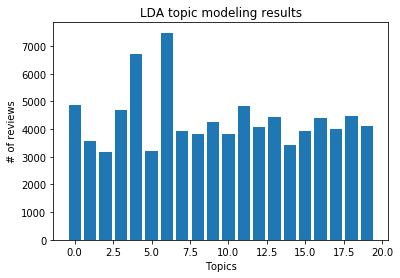

In [169]:
cluster1_distribution=pd.DataFrame(test.groupby(['pro_label'])['pro_label'].count())
cluster1_distribution.index=range(0,20)  
#cluster1_distribution
plt.bar(cluster1_distribution.index,cluster1_distribution.pro_label)
plt.xlabel('Topics')
plt.ylabel('# of reviews')
plt.title('LDA topic modeling results') 

In [ ]:
not clear clutsers: 0,2,7,10,12,15,16,19
1,6: work/project
3: culture
4: flexiblility
5: company brand
8,14: careern growth
9: 'career growth'
11: work environment
13: people
17: opportunity
18: benefit

In [194]:
topics_LDA=test

topics_LDA['pro_topic'] = topics_LDA['pro_label'].\
replace([0,2,7,10,12,15,16,19,1,6,3,4,5,8,14,9,11,13,17,18],\
        ['flexibility','unsplit','people','unsplit','unsplit','unsplit','unsplit','unsplit',\
         'work/projet','work/projet','culture','flexiblility','company brand','career growth','career growth',\
         'work-life','work environment','people','opportunity','benefit'])
           
topics_LDA=topics_LDA.drop(columns=['pro_label'])
topics_LDA.head()
len(topics_LDA)

,pro_text,Employee ID,pro_topic
0,great place learngrow,empReview_14097495,career growth
1,international environment,empReview_12399850,unsplit
2,ample parking,empReview_7904838,culture
3,got good amount help senior technically improve,empReview_17227778,unsplit
4,good people,empReview_13621219,flexiblility


87294

In [195]:
topics_LDA.to_csv('Pros_IBM_LDA.csv')